<a href="https://colab.research.google.com/github/chandrakiranck/Image-Classification-CIFAR/blob/master/cifar_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 43kB/s 
     |████████████████████████████████| 512kB 40.1MB/s 
     |████████████████████████████████| 3.8MB 52.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=7fb56cb8b9bd1c351f7adb05a723da0707e5e112851e1147d8e57dd292268e3f
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: 

## Import Statement

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets , transforms
from torch.optim import lr_scheduler

from tqdm import tqdm

import random
import PIL 
from PIL import Image

from torch.autograd import Variable
from collections import OrderedDict
import math
from pathlib import Path
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch version {torch.__version__}\nPIL version {PIL.__version__}\nDevice {device}")
import os

torch version 1.5.0+cu101
PIL version 7.0.0
Device cuda


## Objective
1. Get more than 93% accuracy
2. Less then 1 million parameter
3. Max 250 Epoch
4. Use Data Augmentation

## Dataset

### Mean and Std calculation for Normalization

In [ ]:
dataset = datasets.CIFAR10(train=True,root="/content/drive/My Drive/CIFAR10/" , download=True)
mean = np.mean(dataset.data ,axis=(0,1,2))
std = np.std(dataset.data ,axis=(0,1,2))
print(f"\nMean is {mean}\nStd dev is  {std}")

Files already downloaded and verified

Mean is [125.30691805 122.95039414 113.86538318]
Std dev is  [62.99321928 62.08870764 66.70489964]


### Transformation and Dataset Defination

In [ ]:
train_transforms = transforms.Compose([transforms.RandomCrop(size=32 , padding=4 , padding_mode="symmetric",pad_if_needed=True),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ToTensor(),
                                       #transforms.Normalize(mean = mean , std=std)
                                      ])

val_transforms = transforms.Compose([transforms.ToTensor() , 
                                     #transforms.Normalize(mean=mean , std=std)
                                    ])

mean = torch.from_numpy(mean).type(torch.float32)
std = torch.from_numpy(std).type(torch.float32)

def denormalize(image):
  image = image.clone().detach().to("cpu") # take out of computational graph
  image = image.squeeze() 
  image = image.permute(1,2,0) # channel swapping H*W*C
 # image.mul_(std).add_(mean) # denormalize

  return image.numpy() 

trainset = datasets.CIFAR10(train=True,root="/content/drive/My Drive/CIFAR10/" , download=True,transform=train_transforms)
valset  = datasets.CIFAR10(train=False,root="/content/drive/My Drive/CIFAR10/" , download=True,transform=val_transforms)

Files already downloaded and verified
Files already downloaded and verified


### Augmentation Visualization
side by side comparison of original Image and augmented Image

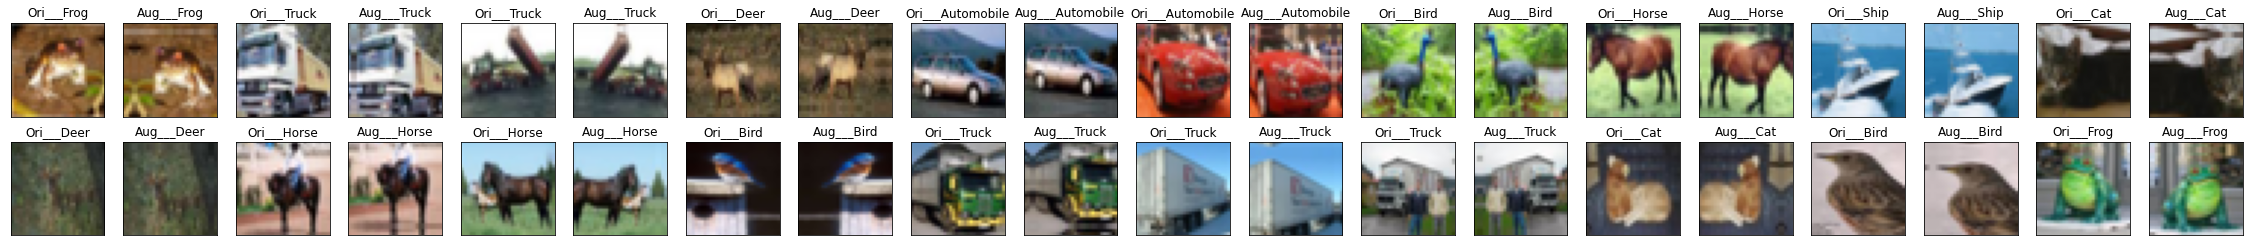

In [ ]:
def show_img(ax,img,text):
  ax.set_xticks([])
  ax.set_yticks([])
  ax.grid(False)
  ax.imshow(img)
  ax.set_title(text.title())

def visualizeAugmentation(augSet , normalset , no_of_images=8):
  """
    Visualizing Augmentation with normal set
    :augset : Augmented dataset
    :normalset :Normal dataset with no Augmentation
  """
  fig = plt.figure(figsize=(no_of_images*2,4))
  
  l = [x for x in range(1,2*no_of_images+1)] #indexing purpose 
  
  for i in range(no_of_images):
    
    ax  = fig.add_subplot(2,no_of_images,l[::2][i]) #odd numbers 
    ax2 = fig.add_subplot(2,no_of_images,l[1::2][i]) #even numbers
    
    show_img(ax , normalset[i][0],f"ori___{normalset.classes[normalset[i][1]]}")
    show_img(ax2 , denormalize(augSet[i][0]) , f"aug___{augSet.classes[augSet[i][1]]}")
  
visualizeAugmentation(trainset , dataset,no_of_images=20)

## Utility Func

###  No grad


In [ ]:
from functools import wraps

def no_grad(func):
  @wraps(func)
  def wrapper(*args,**kwargs):
    with torch.no_grad():
      return func(*args,**kwargs)
  return wrapper

### Save Checkpoint

In [ ]:
def save_checkpoint(epoch, epochs_since_improvement, model, optimizer,loss, best_loss, is_best,filepath=None):
    """
    Save model checkpoint.

    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement
    :param model: model
    :param optimizer: optimizer
    :param loss: validation loss in this epoch
    :param best_loss: best validation loss achieved so far (not necessarily in this checkpoint)
    :param is_best: is this checkpoint the best so far?
    """
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'loss': loss,
             'best_loss': best_loss,
             'model': model.state_dict(),
             'optimizer': optimizer.state_dict()}
    filename = Path("/content/drive/My Drive/CIFAR10/DenseNet/checkpoint.pt") if filepath is None else filepath
    is_best = is_best if filepath is None else False
    torch.save(state, filename)
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    if is_best:
        torch.save(state,   Path("/content/drive/My Drive/CIFAR10/DenseNet/BEST_checkpoint.pt"))

## Model Definition

### Calculate Summary

In [ ]:
@no_grad
def summary(model, input_size, batch_size=-1, device="cuda"):

    def register_hook(module):

        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(summary)

            m_key = "%s-%i" % (class_name, module_idx + 1)
            summary[m_key] = OrderedDict()
            summary[m_key]["input_shape"] = list(input[0].size())
            summary[m_key]["input_shape"][0] = batch_size
            if isinstance(output, (list, tuple)):
                summary[m_key]["output_shape"] = [
                    [-1] + list(o.size())[1:] for o in output
                ]
            else:
                summary[m_key]["output_shape"] = list(output.size())
                summary[m_key]["output_shape"][0] = batch_size

            params = 0
            if hasattr(module, "weight") and hasattr(module.weight, "size"):
                params += torch.prod(torch.LongTensor(list(module.weight.size())))
                summary[m_key]["trainable"] = module.weight.requires_grad
            if hasattr(module, "bias") and hasattr(module.bias, "size"):
                params += torch.prod(torch.LongTensor(list(module.bias.size())))
            summary[m_key]["nb_params"] = params

        if (
            not isinstance(module, nn.Sequential)
            and not isinstance(module, nn.ModuleList)
            and not (module == model)
        ):
            hooks.append(module.register_forward_hook(hook))

    device = device.lower()
    assert device in [
        "cuda",
        "cpu",
    ], "Input device is not valid, please specify 'cuda' or 'cpu'"

    if device == "cuda" and torch.cuda.is_available():
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor

    # multiple inputs to the network
    if isinstance(input_size, tuple):
        input_size = [input_size]

    # batch_size of 2 for batchnorm
    x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]
    # print(type(x[0]))

    # create properties
    summary = OrderedDict()
    hooks = []
    model = model.to(device)
    # register hook
    model.apply(register_hook)

    # make a forward pass
    # print(x.shape)
    model(*x)

    # remove these hooks
    for h in hooks:
        h.remove()

    print("----------------------------------------------------------------")
    line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
    print(line_new)
    print("================================================================")
    total_params = 0
    total_output = 0
    trainable_params = 0
    for layer in summary:
        # input_shape, output_shape, trainable, nb_params
        line_new = "{:>20}  {:>25} {:>15}".format(
            layer,
            str(summary[layer]["output_shape"]),
            "{0:,}".format(summary[layer]["nb_params"]),
        )
        total_params += summary[layer]["nb_params"]
        total_output += np.prod(summary[layer]["output_shape"])
        if "trainable" in summary[layer]:
            if summary[layer]["trainable"] == True:
                trainable_params += summary[layer]["nb_params"]
        print(line_new)

    # assume 4 bytes/number (float on cuda).
    total_input_size = abs(np.prod(input_size) * batch_size * 4. / (1024 ** 2.))
    total_output_size = abs(2. * total_output * 4. / (1024 ** 2.))  # x2 for gradients
    total_params_size = abs(total_params.numpy() * 4. / (1024 ** 2.))
    total_size = total_params_size + total_output_size + total_input_size
    
    del model
    
    print("================================================================")
    print("Total params: {0:,}".format(total_params))
    print("Trainable params: {0:,}".format(trainable_params))
    print("Non-trainable params: {0:,}".format(total_params - trainable_params))
    print("----------------------------------------------------------------")
    print("Input size (MB): %0.2f" % total_input_size)
    print("Forward/backward pass size (MB): %0.2f" % total_output_size)
    print("Params size (MB): %0.2f" % total_params_size)
    print("Estimated Total Size (MB): %0.2f" % total_size)
    print("----------------------------------------------------------------")
    return total_params

### DenseNet-121 BC

In [ ]:

class BottleNeck(nn.Module):
  def __init__(self,num_channels,growth_rate,bn_size,drop_rate):
    super(BottleNeck ,self).__init__()
    mid_channel = int(bn_size*growth_rate)
    self.bn1 = nn.BatchNorm2d(num_channels)
    self.conv1 = nn.Conv2d(num_channels,mid_channel ,kernel_size=1 , bias=False)
    self.bn2 = nn.BatchNorm2d(mid_channel)
    self.conv2 = nn.Conv2d(mid_channel ,growth_rate , kernel_size=3 , bias=False,padding=1)
    self.drop_rate=drop_rate
    
  def forward(self,x):
    new_features = self.conv1(F.leaky_relu(self.bn1(x)))
    new_features = self.conv2(F.leaky_relu(self.bn2(new_features)))
    if self.drop_rate > 0:
      new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
    return torch.cat([x,new_features],1)

In [ ]:



# Bottle Neck test
BottleNeck(24,12,4,0.3)

BottleNeck(
  (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)

In [ ]:
class Transition(nn.Module):
    def __init__(self, num_channels, num_out_channels):
        super(Transition, self).__init__()
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv1 = nn.Conv2d(num_channels, num_out_channels, kernel_size=1,
                               bias=False)

    def forward(self, x):
        out = self.conv1(F.leaky_relu(self.bn1(x)))
        out = F.avg_pool2d(out, 2)
        return out

In [ ]:
class DenseNet(nn.Module):
  
  def __init__(self, growth_rate, depth, reduction , num_classes,bn_size=4,drop_rate=0.15):
    super(DenseNet , self).__init__()
    
    no_of_dense_blocks = (depth-4)//6 #16,
    num_channels = 2*growth_rate #24
    
    self.conv1 = nn.Conv2d(3,num_channels , kernel_size=3 ,padding=1,bias=False) #first conv layer
    
    self.dense_block1 = self._gen_dense_block(num_channels , growth_rate, no_of_dense_blocks,bn_size,drop_rate) # first dense block
    num_channels += no_of_dense_blocks * growth_rate
    num_out_channels = int(math.floor(num_channels*reduction))
    self.trans_block1 = Transition(num_channels , num_out_channels) #first transition block
    
    num_channels = num_out_channels
    self.dense_block2 = self._gen_dense_block(num_channels , growth_rate, no_of_dense_blocks,bn_size,drop_rate) # second dense block
    num_channels += no_of_dense_blocks * growth_rate
    num_out_channels = int(math.floor(num_channels*reduction))
    self.trans_block2 = Transition(num_channels , num_out_channels) #first transition block
    
    num_channels = num_out_channels
    self.dense_block3 = self._gen_dense_block(num_channels , growth_rate, no_of_dense_blocks,bn_size,drop_rate) #third Dense block
    num_channels += no_of_dense_blocks * growth_rate
    
    self.bn1 = nn.BatchNorm2d(num_channels) # final batch norm
    self.pool = nn.AvgPool2d(kernel_size=8, stride=1, padding=0)

    ## classifier
    self.classifier = self.create_head(num_channels , num_classes)

    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.constant_(m.bias, 0)
                
  def _gen_dense_block(self,num_channels , growth_rate, no_of_dense_blocks,bn_size,drop_rate):
    return nn.Sequential(*[ BottleNeck(int(num_channels+i*growth_rate) , growth_rate,bn_size,drop_rate) for i in range(no_of_dense_blocks)]) 
  
  def create_head(self,num_features , number_classes ,dropout_prob=0.15 ,activation_func =nn.LeakyReLU):
    features_lst = [num_features , num_features//2 , num_features//4]
    layers = []
    for in_f ,out_f in zip(features_lst[:-1] , features_lst[1:]):
      layers.append(nn.Linear(in_f , out_f))
      layers.append(activation_func())
      layers.append(nn.BatchNorm1d(out_f))
      if dropout_prob !=0 : layers.append(nn.Dropout(dropout_prob))
    layers.append(nn.Linear(features_lst[-1] , number_classes))
    return nn.Sequential(*layers)

  def forward(self,x):
    x = self.conv1(x)
    x = self.trans_block1(self.dense_block1(x))
    x = self.trans_block2(self.dense_block2(x))
    x = self.pool(F.leaky_relu(self.bn1(self.dense_block3(x))))
    x = x.view(x.size(0) , -1)
    x = self.classifier(x)
    return x

In [ ]:
totalparams = summary(DenseNet(growth_rate=12, depth=100, reduction=0.6 , num_classes=len(trainset.classes)),(3,32,32));totalparams

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]             648
       BatchNorm2d-2           [-1, 24, 32, 32]              48
            Conv2d-3           [-1, 48, 32, 32]           1,152
       BatchNorm2d-4           [-1, 48, 32, 32]              96
            Conv2d-5           [-1, 12, 32, 32]           5,184
        BottleNeck-6           [-1, 36, 32, 32]               0
       BatchNorm2d-7           [-1, 36, 32, 32]              72
            Conv2d-8           [-1, 48, 32, 32]           1,728
       BatchNorm2d-9           [-1, 48, 32, 32]              96
           Conv2d-10           [-1, 12, 32, 32]           5,184
       BottleNeck-11           [-1, 48, 32, 32]               0
      BatchNorm2d-12           [-1, 48, 32, 32]              96
           Conv2d-13           [-1, 48, 32, 32]           2,304
      BatchNorm2d-14           [-1, 48,

tensor(931420)

##  Parameters

In [ ]:
batch_size=32
checkpoint = Path("/content/drive/My Drive/CIFAR10/DenseNet/BEST_checkpoint.pt")
start_epoch = 0  # start at this epoch
epochs = 50  # number of epochs to run without early-stopping
epochs_since_improvement = 0  # number of epochs since there was an improvement in the validation metric
best_loss = 100.  # assume a high loss at first
workers = 4  # number of workers for loading data in the DataLoader
lr = 0.01  # learning rate
weight_decay = 1e-4  # weight decay
n_classes = len(trainset.classes)

## DataLoader

In [ ]:
loader_param = { "batch_size":batch_size,
                 "pin_memory":True,
                 "num_workers":workers,
                "shuffle":True}

trainLoader = DataLoader(trainset,**loader_param)

valLoader = DataLoader(valset  ,**loader_param)


## Averge Meter

In [ ]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Train method

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.

    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: CrossEntropy loss
    :param optimizer :optimizer
    :param epoch: epoch number
    """
    model.train()  # training mode enables dropout

    losses = AverageMeter()  # loss
    accuracy = AverageMeter() # Accuracy meter

    # Batches
    for images, labels in train_loader:
      
        optimizer.zero_grad()
        # Move to default device
        images = images.to(device) 
        labels = labels.to(device)

        # Forward prop.
        output = model(images)  
        preds = torch.argmax(output,1)
        # Loss
        loss = criterion(output, labels)  # scalar

        
        loss.backward()
        
        
        optimizer.step()

        losses.update(loss.item(), images.shape[0])
        accuracy.update(torch.sum(preds == labels.data).item())
        
        # Print status
    print(f"TRAIN  Loss {losses.avg}\t Accuracy {accuracy.sum/len(train_loader.dataset)}")
    return losses.avg

## Validation method

In [ ]:
@no_grad
def validate(val_loader, model, criterion):
    """
    One epoch's validation.

    :param val_loader: DataLoader for training data
    :param model: model
    :param criterion: CrossEntropy loss
    """
    model.eval()  # inference mode enables dropout

    losses = AverageMeter()  # loss
    accuracy = AverageMeter() # Accuracy meter

    # Batches
    for images, labels in val_loader:

        # Move to default device
        images = images.to(device) 
        labels = labels.to(device)

        # Forward prop.
        output = model(images) 
        preds = torch.argmax(output,1)
        # Loss
        loss = criterion(output, labels)  # scalar

        losses.update(loss.item(), images.shape[0])
        accuracy.update(torch.sum(preds == labels.data).item())
        

        # Print status
    print(f"VAL  Loss {losses.avg}\t Accuracy {accuracy.sum/len(val_loader.dataset)}")
    return losses.avg

## Training

In [ ]:
from tqdm import trange
def main(epochs):
  """
  
  Training and validation.
  """
  global epochs_since_improvement, start_epoch, best_loss, checkpoint
  model = DenseNet(growth_rate=12, depth=100, reduction=0.6 , num_classes=n_classes)
  model = model.to(device)

  # specify loss function (categorical cross-entropy)
  criterion = nn.CrossEntropyLoss()

  # specify optimizer
  optimizer = optim.SGD(model.parameters(), lr=lr,weight_decay=weight_decay,momentum=0.9,nesterov=True,dampening=0)
  scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=4,min_lr=1e-5,verbose=True)
  
  # Initialize model or load checkpoint
  if checkpoint.exists():
    checkpoint_dict = torch.load(checkpoint)
    start_epoch = checkpoint_dict['epoch'] + 1
    epochs_since_improvement = checkpoint_dict['epochs_since_improvement']
    best_loss = checkpoint_dict['best_loss']
    print('\nLoaded checkpoint from epoch %d. Best loss so far is %.3f.\n' % (start_epoch, best_loss))
    model.load_state_dict(checkpoint_dict['model'])
    optimizer.load_state_dict(checkpoint_dict['optimizer']) 

  # Epochs
  for epoch in trange(start_epoch,start_epoch+epochs):
      print("Current LR is " , optimizer.param_groups[0]['lr'])
      # One epoch's training
      train_loss = train(train_loader=trainLoader,
                         model=model,
                         criterion=criterion,
                         optimizer=optimizer,
                         epoch=epoch)

      # One epoch's validation
      val_loss = validate(val_loader=valLoader,
                          model=model,
                          criterion=criterion)
      scheduler.step(val_loss)
      # Did validation loss improve?
      is_best = val_loss < best_loss
      best_loss = min(val_loss, best_loss)

      if not is_best:
          epochs_since_improvement += 1
          print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))

      else:
          epochs_since_improvement = 0

      # Save checkpoint
      save_checkpoint(epoch, epochs_since_improvement, model, optimizer, train_loss, best_loss, is_best)
  return model

In [ ]:
model = main(epochs=epochs)

  0%|          | 0/50 [00:00<?, ?it/s]


Loaded checkpoint from epoch 47. Best loss so far is 0.221.

Current LR is  0.001
TRAIN  Loss 0.08287097060203552	 Accuracy 0.97174
VAL  Loss 0.2229133683204651	 Accuracy 0.9336

Epochs since last improvement: 1



  2%|▏         | 1/50 [02:11<1:47:43, 131.91s/it]

Current LR is  0.001
TRAIN  Loss 0.08202949741840362	 Accuracy 0.97112


  4%|▍         | 2/50 [04:22<1:45:18, 131.63s/it]

VAL  Loss 0.2401783093690872	 Accuracy 0.9295

Epochs since last improvement: 2

Current LR is  0.001
TRAIN  Loss 0.07823312842845917	 Accuracy 0.97306


  6%|▌         | 3/50 [06:34<1:42:59, 131.48s/it]

VAL  Loss 0.2300681806087494	 Accuracy 0.9331

Epochs since last improvement: 3

Current LR is  0.001
TRAIN  Loss 0.07601653110027314	 Accuracy 0.97438


  8%|▊         | 4/50 [08:45<1:40:48, 131.48s/it]

VAL  Loss 0.23576272263526918	 Accuracy 0.9319

Epochs since last improvement: 4

Current LR is  0.001
TRAIN  Loss 0.07523756981372834	 Accuracy 0.97362


 10%|█         | 5/50 [10:56<1:38:31, 131.37s/it]

VAL  Loss 0.2276225586652756	 Accuracy 0.936

Epochs since last improvement: 5

Current LR is  0.001
TRAIN  Loss 0.0729984210729599	 Accuracy 0.97512


 12%|█▏        | 6/50 [13:08<1:36:22, 131.42s/it]

VAL  Loss 0.22482432148456574	 Accuracy 0.935
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.

Epochs since last improvement: 6

Current LR is  0.0001
TRAIN  Loss 0.07040251627445221	 Accuracy 0.97578


 14%|█▍        | 7/50 [15:19<1:34:10, 131.40s/it]

VAL  Loss 0.22792892470359802	 Accuracy 0.9346

Epochs since last improvement: 7

Current LR is  0.0001
TRAIN  Loss 0.06590262440681458	 Accuracy 0.97702


 16%|█▌        | 8/50 [17:30<1:31:57, 131.38s/it]

VAL  Loss 0.23410868299007415	 Accuracy 0.9322

Epochs since last improvement: 8

Current LR is  0.0001
TRAIN  Loss 0.0654513497877121	 Accuracy 0.97804


 18%|█▊        | 9/50 [19:41<1:29:41, 131.26s/it]

VAL  Loss 0.22761039693355561	 Accuracy 0.9342

Epochs since last improvement: 9

Current LR is  0.0001
TRAIN  Loss 0.06387221742153168	 Accuracy 0.97838


 20%|██        | 10/50 [21:52<1:27:23, 131.08s/it]

VAL  Loss 0.23133973824977874	 Accuracy 0.9327

Epochs since last improvement: 10

Current LR is  0.0001
TRAIN  Loss 0.06298600273132324	 Accuracy 0.97844


 22%|██▏       | 11/50 [24:03<1:25:12, 131.10s/it]

VAL  Loss 0.2334819115638733	 Accuracy 0.9328
Epoch    11: reducing learning rate of group 0 to 1.0000e-05.

Epochs since last improvement: 11

Current LR is  1e-05
TRAIN  Loss 0.06497372985839844	 Accuracy 0.9778


 24%|██▍       | 12/50 [26:14<1:22:57, 131.00s/it]

VAL  Loss 0.22864388844966888	 Accuracy 0.934

Epochs since last improvement: 12

Current LR is  1e-05
TRAIN  Loss 0.06356526698350906	 Accuracy 0.97884


 26%|██▌       | 13/50 [28:25<1:20:47, 131.01s/it]

VAL  Loss 0.22636334881782533	 Accuracy 0.9347

Epochs since last improvement: 13

Current LR is  1e-05
TRAIN  Loss 0.06391213609218598	 Accuracy 0.9779


 28%|██▊       | 14/50 [30:36<1:18:35, 131.00s/it]

VAL  Loss 0.23535216391086577	 Accuracy 0.9324

Epochs since last improvement: 14

Current LR is  1e-05
TRAIN  Loss 0.06402341930866241	 Accuracy 0.97786


 30%|███       | 15/50 [32:49<1:16:42, 131.50s/it]

VAL  Loss 0.233421395945549	 Accuracy 0.9316

Epochs since last improvement: 15

Current LR is  1e-05
TRAIN  Loss 0.06307310441493988	 Accuracy 0.97928


 32%|███▏      | 16/50 [35:02<1:14:46, 131.96s/it]

VAL  Loss 0.22638384003639223	 Accuracy 0.9338

Epochs since last improvement: 16

Current LR is  1e-05
TRAIN  Loss 0.06446751175403595	 Accuracy 0.9776


 34%|███▍      | 17/50 [37:14<1:12:40, 132.13s/it]

VAL  Loss 0.23031396594047546	 Accuracy 0.9337

Epochs since last improvement: 17

Current LR is  1e-05
TRAIN  Loss 0.06454865196704865	 Accuracy 0.97756


 36%|███▌      | 18/50 [39:26<1:10:25, 132.04s/it]

VAL  Loss 0.22924839808940886	 Accuracy 0.9345

Epochs since last improvement: 18

Current LR is  1e-05
TRAIN  Loss 0.06501596297264099	 Accuracy 0.97678


 38%|███▊      | 19/50 [41:38<1:08:09, 131.91s/it]

VAL  Loss 0.23243083791732788	 Accuracy 0.9324

Epochs since last improvement: 19

Current LR is  1e-05
TRAIN  Loss 0.062387865114212036	 Accuracy 0.97906


 40%|████      | 20/50 [43:50<1:05:59, 131.98s/it]

VAL  Loss 0.23369595429897308	 Accuracy 0.9308

Epochs since last improvement: 20

Current LR is  1e-05
TRAIN  Loss 0.06300446500778198	 Accuracy 0.97856


 42%|████▏     | 21/50 [46:00<1:03:33, 131.52s/it]

VAL  Loss 0.22954316947460174	 Accuracy 0.9344

Epochs since last improvement: 21

Current LR is  1e-05
TRAIN  Loss 0.0636780753326416	 Accuracy 0.97846


 44%|████▍     | 22/50 [48:10<1:01:11, 131.12s/it]

VAL  Loss 0.2259673944711685	 Accuracy 0.9344

Epochs since last improvement: 22

Current LR is  1e-05
TRAIN  Loss 0.06372936344861985	 Accuracy 0.9781


 46%|████▌     | 23/50 [50:20<58:51, 130.79s/it]  

VAL  Loss 0.22986490340232849	 Accuracy 0.9336

Epochs since last improvement: 23

Current LR is  1e-05
TRAIN  Loss 0.06596561561584473	 Accuracy 0.97706


 48%|████▊     | 24/50 [52:33<56:52, 131.26s/it]

VAL  Loss 0.23148348863124849	 Accuracy 0.9322

Epochs since last improvement: 24

Current LR is  1e-05
TRAIN  Loss 0.06340690361022949	 Accuracy 0.97788


 50%|█████     | 25/50 [54:44<54:41, 131.26s/it]

VAL  Loss 0.2286711202144623	 Accuracy 0.9339

Epochs since last improvement: 25

Current LR is  1e-05
TRAIN  Loss 0.06474092821598053	 Accuracy 0.97808


 52%|█████▏    | 26/50 [56:56<52:35, 131.50s/it]

VAL  Loss 0.2291241482257843	 Accuracy 0.934

Epochs since last improvement: 26

Current LR is  1e-05
TRAIN  Loss 0.06430389449596405	 Accuracy 0.9774


 54%|█████▍    | 27/50 [59:08<50:27, 131.64s/it]

VAL  Loss 0.23230922346115113	 Accuracy 0.9339

Epochs since last improvement: 27

Current LR is  1e-05
TRAIN  Loss 0.06284027347564697	 Accuracy 0.97858


 56%|█████▌    | 28/50 [1:01:20<48:16, 131.68s/it]

VAL  Loss 0.23209695165157318	 Accuracy 0.9334

Epochs since last improvement: 28

Current LR is  1e-05
TRAIN  Loss 0.06380714560985565	 Accuracy 0.97826


 58%|█████▊    | 29/50 [1:03:31<46:05, 131.68s/it]

VAL  Loss 0.23146929681301118	 Accuracy 0.9329

Epochs since last improvement: 29

Current LR is  1e-05
TRAIN  Loss 0.06440873323440552	 Accuracy 0.97876


 60%|██████    | 30/50 [1:05:42<43:49, 131.45s/it]

VAL  Loss 0.23483514902591707	 Accuracy 0.9331

Epochs since last improvement: 30

Current LR is  1e-05
TRAIN  Loss 0.06499133347511292	 Accuracy 0.97756


 62%|██████▏   | 31/50 [1:07:53<41:35, 131.33s/it]

VAL  Loss 0.23383901510238647	 Accuracy 0.9321

Epochs since last improvement: 31

Current LR is  1e-05
TRAIN  Loss 0.0645888645362854	 Accuracy 0.97728


 64%|██████▍   | 32/50 [1:10:05<39:25, 131.43s/it]

VAL  Loss 0.22944780735969544	 Accuracy 0.9338

Epochs since last improvement: 32

Current LR is  1e-05
TRAIN  Loss 0.06227873876094818	 Accuracy 0.97852


 66%|██████▌   | 33/50 [1:12:17<37:16, 131.56s/it]

VAL  Loss 0.22651186628341674	 Accuracy 0.9347

Epochs since last improvement: 33

Current LR is  1e-05
TRAIN  Loss 0.0621059876203537	 Accuracy 0.97848


 68%|██████▊   | 34/50 [1:14:30<35:10, 131.93s/it]

VAL  Loss 0.23011656692028046	 Accuracy 0.933

Epochs since last improvement: 34

Current LR is  1e-05
TRAIN  Loss 0.06454039359092713	 Accuracy 0.9779


 70%|███████   | 35/50 [1:16:43<33:03, 132.22s/it]

VAL  Loss 0.2228767437696457	 Accuracy 0.9351

Epochs since last improvement: 35

Current LR is  1e-05
TRAIN  Loss 0.0628750384759903	 Accuracy 0.97896


 72%|███████▏  | 36/50 [1:18:55<30:50, 132.17s/it]

VAL  Loss 0.23228511068820953	 Accuracy 0.9334

Epochs since last improvement: 36

Current LR is  1e-05
TRAIN  Loss 0.061737588186264035	 Accuracy 0.9784


 74%|███████▍  | 37/50 [1:21:09<28:47, 132.89s/it]

VAL  Loss 0.2371156947851181	 Accuracy 0.9324

Epochs since last improvement: 37

Current LR is  1e-05
TRAIN  Loss 0.061060611276626583	 Accuracy 0.9786


 76%|███████▌  | 38/50 [1:23:22<26:34, 132.92s/it]

VAL  Loss 0.2253761081933975	 Accuracy 0.9355

Epochs since last improvement: 38

Current LR is  1e-05
TRAIN  Loss 0.06400002746582031	 Accuracy 0.97796


 78%|███████▊  | 39/50 [1:25:36<24:25, 133.21s/it]

VAL  Loss 0.23275041875839234	 Accuracy 0.9341

Epochs since last improvement: 39

Current LR is  1e-05
TRAIN  Loss 0.06325724601268769	 Accuracy 0.97886


 80%|████████  | 40/50 [1:27:50<22:13, 133.30s/it]

VAL  Loss 0.23708742690086365	 Accuracy 0.9318

Epochs since last improvement: 40

Current LR is  1e-05
TRAIN  Loss 0.06324406929969788	 Accuracy 0.9788


 82%|████████▏ | 41/50 [1:30:03<20:00, 133.42s/it]

VAL  Loss 0.23316483418941497	 Accuracy 0.9342

Epochs since last improvement: 41

Current LR is  1e-05
TRAIN  Loss 0.06237976714134216	 Accuracy 0.97912


 84%|████████▍ | 42/50 [1:32:19<17:52, 134.09s/it]

VAL  Loss 0.23243907444477083	 Accuracy 0.9333

Epochs since last improvement: 42

Current LR is  1e-05
TRAIN  Loss 0.06162110157966614	 Accuracy 0.97872


 86%|████████▌ | 43/50 [1:34:36<15:45, 135.01s/it]

VAL  Loss 0.2317953477859497	 Accuracy 0.9315

Epochs since last improvement: 43

Current LR is  1e-05
TRAIN  Loss 0.06313736871719361	 Accuracy 0.97878
VAL  Loss 0.225048028922081	 Accuracy 0.9346

Epochs since last improvement: 44



 88%|████████▊ | 44/50 [1:36:52<13:31, 135.20s/it]

Current LR is  1e-05
TRAIN  Loss 0.06497069910049438	 Accuracy 0.97798


 90%|█████████ | 45/50 [1:39:08<11:17, 135.43s/it]

VAL  Loss 0.23379860668182373	 Accuracy 0.9327

Epochs since last improvement: 45

Current LR is  1e-05
TRAIN  Loss 0.06540724199295044	 Accuracy 0.9765


 92%|█████████▏| 46/50 [1:41:24<09:02, 135.73s/it]

VAL  Loss 0.2333701244354248	 Accuracy 0.9325

Epochs since last improvement: 46

Current LR is  1e-05
TRAIN  Loss 0.059712833518981934	 Accuracy 0.98018


 94%|█████████▍| 47/50 [1:43:41<06:47, 135.94s/it]

VAL  Loss 0.22379205532073976	 Accuracy 0.935

Epochs since last improvement: 47

Current LR is  1e-05
TRAIN  Loss 0.06346971997261047	 Accuracy 0.97838


 96%|█████████▌| 48/50 [1:45:56<04:31, 135.92s/it]

VAL  Loss 0.23162222685813905	 Accuracy 0.9324

Epochs since last improvement: 48

Current LR is  1e-05
TRAIN  Loss 0.06330037610054016	 Accuracy 0.97814


 98%|█████████▊| 49/50 [1:48:12<02:15, 135.68s/it]

VAL  Loss 0.22509935700893402	 Accuracy 0.9338

Epochs since last improvement: 49

Current LR is  1e-05
TRAIN  Loss 0.06027452730178833	 Accuracy 0.98022


100%|██████████| 50/50 [1:50:26<00:00, 132.54s/it]

VAL  Loss 0.22567172136306762	 Accuracy 0.9345

Epochs since last improvement: 50



## Per Class Accuracy

In [ ]:
## load the model
@no_grad
def perClassAccuracy(model , classes):
  model = main(epochs=0)
  class_correct = np.zeros(len(classes) ,dtype =np.int64 )
  class_total = np.zeros_like(class_correct,dtype =np.int64 )
  model.eval()
  
  for data ,target in valLoader:
    data,target =data.to(device) , target.to(device)
    output =model(data)
    preds = torch.argmax(output,1)
    for prediction , label in zip(preds , target.data):
      if prediction == label:
        class_correct[prediction]+=1
      class_total[label]+=1
  per = np.round((100*class_correct/class_total) ,4)
  out = "\n".join([f"{name} :- {acc} %" for name ,acc in zip(classes , per)])
  return out+"\ntotal acc is {0}%".format(100* sum(class_correct)/sum(class_total))

print(perClassAccuracy(model , trainset.classes))

0it [00:00, ?it/s]


Loaded checkpoint from epoch 47. Best loss so far is 0.221.



airplane :- 95.3 %
automobile :- 97.8 %
bird :- 91.3 %
cat :- 89.3 %
deer :- 92.8 %
dog :- 86.9 %
frog :- 94.3 %
horse :- 95.1 %
ship :- 95.7 %
truck :- 95.0 %
total acc is 93.35%


## Intermediate Result :- 93.35% Accuracy

## Visualizing the wrong prediction and where exactly model is confused

In [ ]:
## load the model
model = main(epochs=0)
@no_grad
def allwrong_prediction(classes ,model):
  test_array =[]
  model.eval()
  for data ,target in valLoader:
    data,target =data.to(device) , target.to(device)
    output =model(data)
    preds = torch.argmax(output,1)
    for prediction , label in zip(preds , target.data):
      if prediction != label:
          test_array.append([data ,classes[prediction] ,classes[label]])
  return test_array

s = allwrong_prediction(trainset.classes , model)

0it [00:00, ?it/s]


Loaded checkpoint from epoch 47. Best loss so far is 0.221.



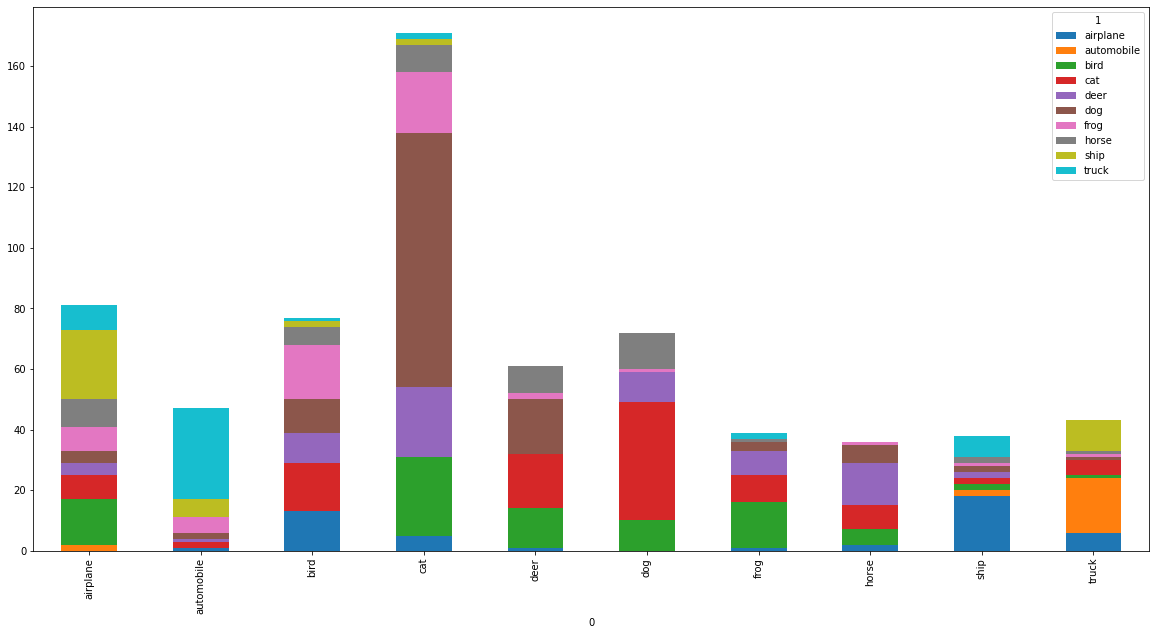

In [ ]:
s_d = [(y,z) for x ,y,z in s]
df = pd.DataFrame(s_d)
gr = df.groupby([0,1])
gr.apply(len).unstack().plot(kind='bar', stacked=True, figsize=(20,10))

## Inferencing Graph
 Model is confused between airplane,ship,bird

## plot confusion matrix


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
model = main(0)
pred = []
la=[]
with torch.no_grad():
  for image , label in valLoader:
    image , label = image.to(device) , label.to(device)
    output = model(image)
    output = F.softmax(output,dim=1)
    preds = torch.argmax(output,dim=1)
    pred.extend(preds.clone().detach().cpu().tolist())
    la.extend(label.clone().detach().cpu().tolist())


0it [00:00, ?it/s]


Loaded checkpoint from epoch 47. Best loss so far is 0.221.



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


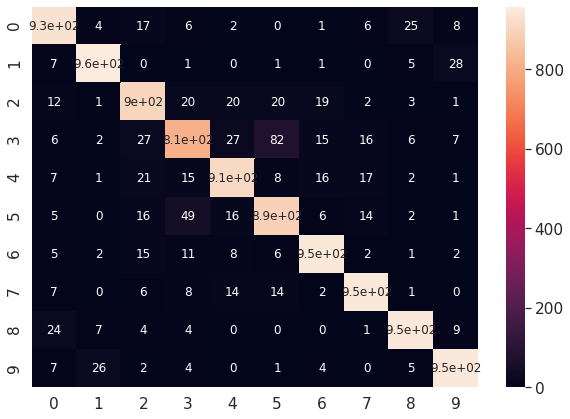

In [ ]:
cm = confusion_matrix(la,
                      pred)
 
# Visualizing of confusion matrix
import seaborn as sn
 
df_cm = pd.DataFrame(cm, range(10),
                  range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size